# Data

In [1]:
from conf import *
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

DATABASE_ROOT = "../../../../ResultsCenter/db/liverpool.db"
DB = database.SQLiteDB(DATABASE_ROOT)

sql = """
    SELECT id, batch, original_crop_pos, speckle_crop_pos, image_path
    FROM mmf_dataset_metadata
    WHERE is_calibration = 0
"""

df = DB.sql_select(sql)
print('number of records in the table: ' + str(len(df)))
df.head(5)

--------------------------------------------------------------------------------
3 table(s) found in the database:
mmf_dataset_metadata
mmf_experiment_config
sqlite_sequence
--------------------------------------------------------------------------------
number of records in the table: 8216


,id,batch,original_crop_pos,speckle_crop_pos,image_path
0,2,1,"((2054, 432), (2214, 592))","((4054, 564), (4286, 796))",C:\Users\qiyuanxu\Documents\ResultsCenter\data...
1,3,1,"((2054, 432), (2214, 592))","((4054, 564), (4286, 796))",C:\Users\qiyuanxu\Documents\ResultsCenter\data...
2,4,1,"((2054, 432), (2214, 592))","((4054, 564), (4286, 796))",C:\Users\qiyuanxu\Documents\ResultsCenter\data...
3,5,1,"((2054, 432), (2214, 592))","((4054, 564), (4286, 796))",C:\Users\qiyuanxu\Documents\ResultsCenter\data...
4,6,1,"((2054, 432), (2214, 592))","((4054, 564), (4286, 796))",C:\Users\qiyuanxu\Documents\ResultsCenter\data...


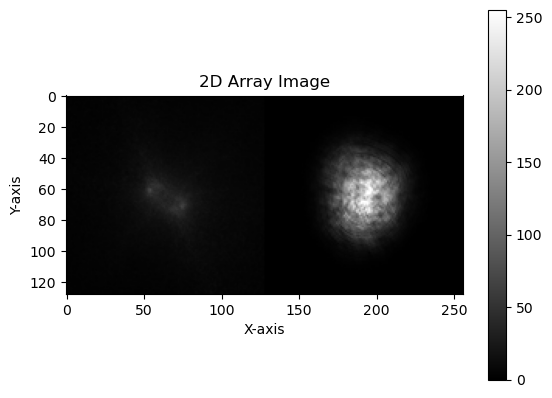

(128, 256)


In [2]:
def data_pipeline(df, batch_size=16):
    # Resize dimensions
    max_height, max_width = 128, 128
    batch_x, batch_y = [], []
    for index, row in df.iterrows():
        img = Image.open(row['image_path']).convert('L')  # Convert to grayscale
        crop_x, crop_y = eval(row["speckle_crop_pos"]), eval(row["original_crop_pos"])
        crop_x = tuple(item for subtuple in crop_x for item in subtuple)
        crop_y = tuple(item for subtuple in crop_y for item in subtuple)
        img_x = img.crop(crop_x)
        img_y = img.crop(crop_y)
        img_x = img_x.resize((max_width, max_height))
        img_y = img_y.resize((max_width, max_height))
        batch_x.append(np.array(img_x)) 
        batch_y.append(np.array(img_y)) 
        # Yield a batch when the specified batch size is reached
        if len(batch_x) >= batch_size:
            res_x = np.stack(batch_x)
            res_y = np.stack(batch_y)
            yield res_x, res_y
            batch_x, batch_y = [], [] 
    # Yield any remaining data as the last batch (if there's any)
    if batch_x or batch_y:
        yield np.stack(batch_x), np.stack(batch_y)
        
train = data_pipeline(df[df['batch'].isin([2])])
valid = data_pipeline(df[df['batch'].isin([1])])
test = data_pipeline(df[df['batch'].isin([4])])

for original, speckle in train:
    combine = np.concatenate((original[0], speckle[0]), axis=1)
    visualization.plot_narray(combine)
    print(combine.shape)
    break

# Model

In [3]:
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

class Autoencoder(Model):
    def __init__(self, latent_dim, shape):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.shape = shape
        self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
          layers.Reshape(shape)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

shape = (128, 128)
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

# Build the model by providing a batch of inputs
# x_dummy = tf.random.normal([1, *shape])  # Create a dummy batch of inputs
# autoencoder(x_dummy)
# tf.keras.utils.plot_model(autoencoder, show_shapes=True, dpi=64)

In [4]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

class DisplayCallback(Callback):
    def __init__(self, model, test_data_generator, num_images=5):
        super(DisplayCallback, self).__init__()
        self.model = model
        self.test_data_generator = test_data_generator
        self.num_images = num_images

    def on_epoch_end(self, epoch, logs=None):
        # Get a batch of test data
        x_test, _ = next(self.test_data_generator)
        
        # Get reconstructed images
        reconstructed_images = self.model.predict(x_test)
        
        # Plot the original and reconstructed images
        plt.figure(figsize=(15, 5))
        for i in range(self.num_images):
            # Original images
            ax = plt.subplot(2, self.num_images, i + 1)
            plt.imshow(x_test[i].reshape(128, 128), cmap="gray")
            plt.title("Original")
            plt.axis("off")

            # Reconstructed images
            ax = plt.subplot(2, self.num_images, i + 1 + self.num_images)
            plt.imshow(reconstructed_images[i].reshape(128, 128), cmap="gray")
            plt.title("Reconstructed")
            plt.axis("off")

        plt.tight_layout()
        plt.show()

display_callback = DisplayCallback(autoencoder, test_data_generator=test)

Epoch 1/10

1/1 [==============================] - 0s 143ms/step


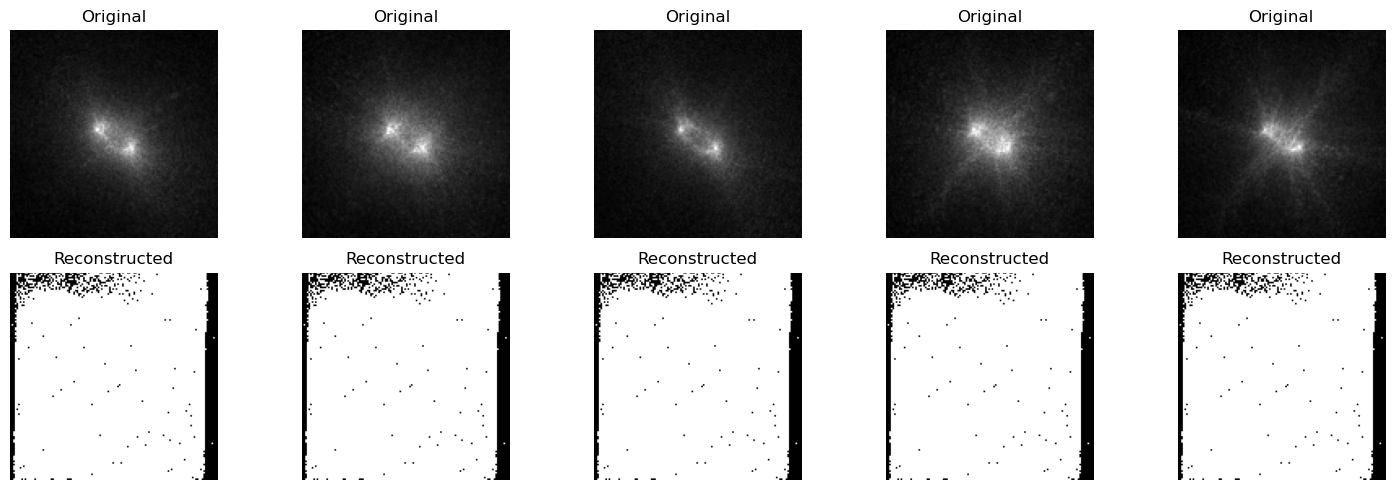

79/79 [==============================] - 68s 858ms/step - loss: 3768.3655 - val_loss: 293.6356
Epoch 2/10
1/1 [==============================] - 0s 33ms/step


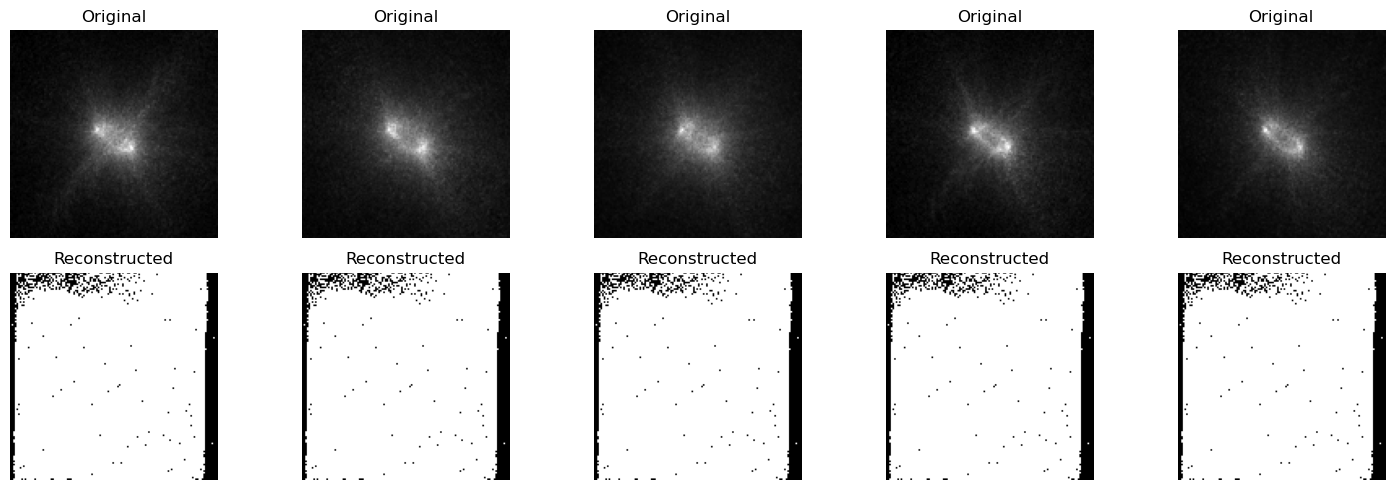

79/79 [==============================] - 1s 17ms/step - loss: 0.0000e+00


In [5]:
autoencoder.fit(train,
                epochs=10,
                shuffle=True,
                validation_data=valid,
                callbacks=[display_callback])

# steps_per_epoch   validation_steps

# Result

In [ ]:
next()
encoded_imgs = autoencoder.encoder().numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
